## Install dependencies and compile the library


In [1]:
!pip install mrob

You should consider upgrading via the 'd:\projects\jupyter\env\scripts\python.exe -m pip install --upgrade pip' command.


## Check if everything exists

In [2]:
import sys
import mrob

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


In [3]:
points_dict = load_obj('data')

X = points_dict['X']
Y = points_dict['Y']
S = points_dict['S']

points_dict

{'X': array([[ 0.11997442, -1.71064665,  0.39654582],
        [-0.52757416,  1.05175794, -0.72296043],
        [ 0.33229886,  2.37956057, -0.31317044],
        [-1.97192188,  0.24477604,  0.97741252],
        [ 0.07198484, -1.75136042, -0.07759415],
        [-1.10131185,  1.43641211, -0.12298213],
        [-0.05644735,  1.15017323,  0.37036048],
        [ 0.1223025 ,  1.65193901, -0.44323297],
        [-0.45656441,  0.58528613, -0.86142219],
        [-1.2176535 , -1.04667782,  0.12013538],
        [-2.0300703 , -0.36106919,  1.24359374],
        [ 1.61518753, -0.70700374, -0.06469358],
        [ 0.35387184,  0.37689621,  1.02997217],
        [ 0.18017012, -0.3138636 , -2.00769752],
        [-2.39772525, -0.27741886, -1.23666329],
        [ 0.58716139, -0.99930925,  0.09630978],
        [ 0.37992645, -0.49060292,  0.61688359],
        [-1.68342393, -2.45511748, -0.58139972],
        [-0.68515293,  0.34996232,  0.60663218],
        [ 0.29694787, -1.08626237,  0.6159761 ]]),
 'Y': array([

## Task 1.A


# Point Cloud Aligment by Gradient Descent

you will be given two arrays, X and Y where the correspondances are known (index in the array), the problem is to find a RBT such that
$$ C(T) = \frac{1}{2}\sum_{i=0}^{N-1} || Tx_i - y_i||^2_{\Sigma_i} = \frac{1}{2}\sum_{i=0}^{N-1} || r_i(T)||^2_{\Sigma_i} \to \min_{T}$$

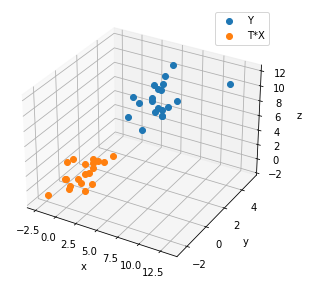

In [11]:
def scatter3D(pcdX, pcdY, T):
    """
    This function plot pcdY and T*pcdX
    """
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    pcdX = T.transform_array(pcdX)
    ax.plot(pcdY[:,0], pcdY[:,1], pcdY[:,2], 'o', label='Y')
    ax.plot(pcdX[:,0], pcdX[:,1], pcdX[:,2], 'o', label='T*X')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.tight_layout()


I = mrob.geometry.SE3(np.zeros(6))
scatter3D(X, Y, I)


### Task 1.B Alignment error




In [67]:
def C(pcdX, pcdY, Cov, T): # Mahalanobis
    """
    Calculate alignment error as a Mahalanobis distance
    """
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"

    R = T.transform_array(pcdX) - pcdY
#     print(R.shape)
#     print((R.reshape(20, 1, 3) @ np.linalg.inv(Cov)).reshape(20, 3).shape)
    resid = (R.reshape(20, 1, 3) @ np.linalg.inv(Cov)).reshape(20, 3) @ R.T # 
    return np.trace(resid)

T = mrob.geometry.SE3(np.zeros(6)) # random T
print("Mahalanobis distance : ", C(X, Y, S, T))
T = mrob.geometry.SE3(load_obj('T'))
print("Mahalanobis distance : ", C(X, Y, S, T))

Mahalanobis distance :  21989524.46759091
Mahalanobis distance :  49.003574101427404


### Task 1.C Gradient

$\nabla_{\xi}C_T(\Delta\xi)= \sum\frac{\partial}{\partial \Delta \xi} (r_i) \Sigma^{-1}r_i$

In [54]:
def gradient(pcdX, pcdY, S, T):
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"
    grad = np.zeros(6)
    R = T.transform_array(pcdX) -  pcdY
    for i in range(pcdX.shape[0]): 
        r = np.dot(R[i], np.linalg.inv(S[i]))
        rot = skew(T.transform(pcdX[i]))
        grad_i = np.hstack( (-rot , np.eye(3)))
        grad = grad + r.T @ grad_i
    return grad

T = mrob.geometry.SE3(np.zeros(6))
gradient(X, Y, S, T)

array([   22076.38721072, -1215653.73313155, -5237119.62555151,
       -3075321.07552742,   -80008.2013959 ,    -6970.49691237])

### Task 1.D Update

In [55]:
alphas = 10**-6 * np.array([0.1,0.1,0.1,0.1,0.1,0.1])
def update(grad, T, alpha=alphas):
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"
    T.update_lhs(-alpha * grad) # update left hand side (T_ = dT.T() * T_;) 
    return T

T = mrob.geometry.SE3(np.zeros(6))
print("Error before", C(X,Y,S,T))
grad = gradient(X, Y, S, T)
T = update(grad, T)
print("Error after", C(X,Y,S,T))

Error before 21989524.46759091
Error after 15347098.919170618


### Task 1.E Convergence

Number of iterations 8000


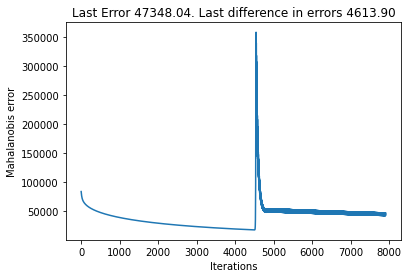

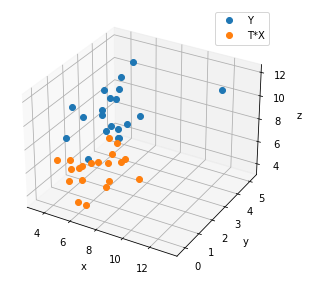

In [58]:
errors = []

T = mrob.geometry.SE3(np.zeros(6))
i = 0
while (i < 8000 and not (len(errors) > 2 and not abs(errors[-2] - errors[-1]) > 0.0001)):
    grad = gradient(X, Y, S, T)
    T = update(grad, T)
    errors.append(C(X,Y,S,T)) # mahalanobis error
    i += 1

print("Number of iterations", i)
fig = plt.figure()
ax = plt.subplot()
plt.plot(errors[90:]) # 
plt.xlabel("Iterations")
plt.ylabel("Mahalanobis error")
err = "%.2f" % errors[-1]
diffErr = "%.2f" % abs(errors[-2] - errors[-1])
plt.title(f"Last Error {err}. Last difference in errors {diffErr}")
scatter3D(X, Y, T)
T1 = T.T

Comment: Point Cloud Alignment by Gradient Descent takes a lot of iterations and cannot be applied in real-time systems, where number of points each seconds can be 1 million and more.


### Task 2.A

In [59]:
def GaussNewton(pcdX, pcdY, S, T):
    """
    Return Gradient and Hessian matrix
    """
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"
    grad = np.zeros(6)
    hessian = np.zeros(6)
    R = T.transform_array(pcdX) -  pcdY

    for i in range(pcdX.shape[0]):
        # gradient 
        inv_Cov = np.linalg.inv(S[i])
        r = np.dot(R[i], inv_Cov)
        rot = skew(T.transform(pcdX[i]))
        grad_i = np.hstack( (-rot , np.eye(3)))
        grad = grad + r @ grad_i
        # hessian
        hessian = hessian + grad_i.T @ inv_Cov @ grad_i
        
    return grad, hessian

T = mrob.geometry.SE3(np.zeros(6))
GaussNewton(X, Y, S, T)

(array([   22076.38721072, -1215653.73313155, -5237119.62555151,
        -3075321.07552742,   -80008.2013959 ,    -6970.49691237]),
 array([[ 6.06026325e+03,  6.12959459e+01, -9.18721902e+02,
          0.00000000e+00, -9.37723505e+03,  8.60701794e+02],
        [ 6.12959459e+01,  6.93795417e+04,  2.94183015e+05,
          1.72540817e+05,  0.00000000e+00,  5.37514432e+01],
        [-9.18721902e+02,  2.94183015e+05,  1.27392572e+06,
          7.41902355e+05,  2.51583802e+03,  0.00000000e+00],
        [ 0.00000000e+00,  1.72540817e+05,  7.41902355e+05,
          4.37036468e+05,  0.00000000e+00,  0.00000000e+00],
        [-9.37723505e+03,  0.00000000e+00,  2.51583802e+03,
          0.00000000e+00,  2.35034249e+04,  0.00000000e+00],
        [ 8.60701794e+02,  5.37514432e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  6.84847794e+02]]))

### Task 2.B Update

In [60]:
alpha = 1
def updateGN(grad, T, alpha=alpha):
    assert isinstance(T, mrob.geometry.SE3), "T Should be an instance mrob.SE3"
    # alpha = 0.01*np.hstack((0.1*np.ones(3),np.ones(3)))
    T.update_lhs(-alpha * grad)
    return T


### Task 2.C


Number of iterations  5
Result matrix


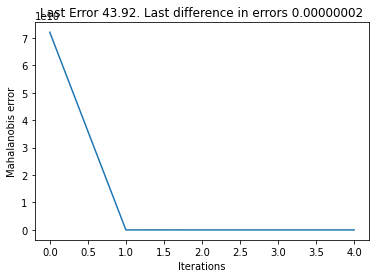

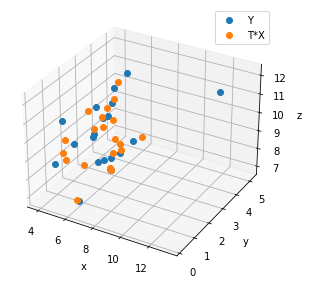

In [68]:
errors = []

T = mrob.geometry.SE3([0.5, 0.5, 0.5, 1000, 2000, 3000])
i = 0
while (i < 100 and not (len(errors) > 2 and not abs(errors[-2] - errors[-1]) > 0.0001)):
    grad, hessian = GaussNewton(X, Y, S, T)
    k = np.linalg.inv(hessian) @ grad
    T = updateGN(k, T)
    errors.append(C(X,Y,S,T)) # mahalanobis error
    i += 1

print("Number of iterations ", i)
fig = plt.figure()
plt.plot(errors) # 
plt.xlabel("Iterations")
plt.ylabel("Mahalanobis error")
err = "%.2f" % errors[-1]
diffErr = "%.8f" % abs(errors[-2] - errors[-1])
plt.title(f"Last Error {err}. Last difference in errors {diffErr}")
scatter3D(X, Y, T)
print("Result matrix")
T2 = T.T()

In [62]:
T_optimal = load_obj('T')
print("Gradient descent resut\n", T1())
print("Gauss-Newton resut\n", T2)
print("Optimal resut\n", T_optimal)

Gradient descent resut
 [[-0.16928976 -0.92813214  0.33152936  5.73523128]
 [ 0.26667647 -0.3669738  -0.89118679  1.32713284]
 [ 0.94880168 -0.06245772  0.30963591  5.8483593 ]
 [ 0.          0.          0.          1.        ]]
Gauss-Newton resut
 [[ 0.74565805 -0.49892298  0.44166722  6.04601232]
 [ 0.65954716  0.45831234 -0.59577457  2.65716594]
 [ 0.09482408  0.73554446  0.67080753  9.16868537]
 [ 0.          0.          0.          1.        ]]
Optimal resut
 [[ 0.7438831  -0.50134356  0.44191919  6.04302334]
 [ 0.65938053  0.44284877 -0.60753789  2.62663025]
 [ 0.10888184  0.74333008  0.66000389  9.21214559]
 [ 0.          0.          0.          1.        ]]


Comment: Gauss-Newton show better result than Gradient descent. Gauss-Newton self regulated and provied good estimation rather than Gradient descent.

And also in gradient descent easy to overshoot update size, which leads to increasing error.